<a href="https://colab.research.google.com/github/ingcoder/ML-MD/blob/main/trajectory/e3nn_trajectory_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting 3D trajectory of Toluene using e3nn
This notebook uses e3nn, an equivariant graph neural network framework, to train a simple GNN model to predict the position of points (atoms) in the next frame based on the previous frame. 
The training data were generated via MD simulation and downloaded from sgdml. 


I had difficulties to achieve a good trajectory prediction with a learning rate of 1e-4 and ca. 1000 training data. 
Decreasing the learning rate to 1e-8 gave much better results, but the loss doesn't converge for 16 epochs and decreases linearly. 
A lr of 1e-15 produced even better prediction but the loss remained constant at 1. Basically the model wasn't training. Not sure what is going on there. Are we learning anything or are we just embedding the position back and forth? 

In [ ]:
# !pip install 
# !pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-geometric # installation different on M1 machine
# !pip install e3nn
# !pip install rdkit
# !pip install torch_cluster
# !pip install plotly
# !pip install py3Dmol
# !pip install wandb

In [ ]:
# ML
import torch
from torch import nn
import torch_geometric
import e3nn
from e3nn.nn.models.gate_points_2101 import Network

# visualization
import py3Dmol
import rdkit
from rdkit import Chem 
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# logging
import wandb

# computation
import numpy as np
import random

# system
import urllib
import shutil

## Helper functions

In [ ]:
# helper functions
# https://birdlet.github.io/2019/10/02/py3dmol_example/
def mol_to_3Dview(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smile_to_mol(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

def project_to_2D(points3d):
    # Define the intrinsic camera matrix
    fx = 500 # 500 focal length in x-direction
    fy = 500 # 500 focal length in y-direction
    cx = 100 # 320 # x-coordinate of the principal point
    cy = 100 # 240 # y-coordinate of the principal point
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    # Define the extrinsic camera matrix (pose)
    R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) # rotation matrix
    t = np.array([0, 0, 5]) # translation vector
    T = np.hstack((R, t.reshape(-1, 1))) # extrinsic matrix
    x = np.ones((points3d.shape[0], 1))
    
    # Apply the camera projection matrix to the 3D points
    points3d_hom = np.hstack((points3d, np.ones((points3d.shape[0], 1)))) # homogeneous coordinates
    points2d_hom = np.dot(K, np.dot(T, points3d_hom.T)).T # homogeneous coordinates
    points2d = points2d_hom[:,:2] / points2d_hom[:,2:3] # normalized coordinates
    return points2d, points3d

def plotly_3D_scatter(data):
    """Draw one or two plotly 3D scatter (sub)plots
    
    Args:
    ----
        data: numpy array, sample data 
    Return:
    ----
        fig: plotly figure
    """
    fig = go.Figure()
    frame = 0
    opacity=0.1
    for i in range(data.shape[0]):
        fig.add_trace(go.Scatter3d(x=data[i, :, 0], y=data[i, :, 1], z=data[i, :, 2],
                                mode='markers', 
                                marker=dict(
                                    color="blue",
                                    size=15,
                                    opacity=0.1
                                )
                                ), )

        frame +=100
        opacity +=0.001
    return fig

def set_torch_geometric_dataset(features, labels):
    # make torch_geometric dataset as an iterable list
    # # x = None because we have no input features
    traj_data = []
    for frame, label in zip(features, labels):
        traj_data.append(
            torch_geometric.data.Data(
                x=None, pos=frame.to(torch.float32), y=label.to(torch.float32)
            )
        )
    data_loader = torch_geometric.loader.DataLoader(
        traj_data, batch_size=1, shuffle=False
    )
    return data_loader

def print_summary(file_path):
    print(f"""
    File Summary
    =======
    Name of training file: {file_path["name"]}
    files: {file_path.files}
    Number of frames: {len(file_path["R"])}
    Number of atoms per frame: {len(file_path["z"])}
    Positions: {file_path["R"].shape}
    Forces: {file_path["F"].shape}, 
    Energy: {file_path["E"].shape}, 
    """)

## Load and visualize training samples

In [ ]:
# urllib.request.urlretrieve(
#      "http://quantum-machine.org/gdml/data/npz/toluene_ccsd_t.zip", "../data/paths.zip"
# )
# shutil.unpack_archive('../data/paths.zip', '../data/paths')
train_file = np.load("../data/paths/toluene_ccsd_t-train.npz")
test_file = np.load("../data/paths/toluene_ccsd_t-test.npz")
train_samples = train_file["R"]
val_samples = test_file["R"]
print_summary(train_file)
print_summary(test_file)


    File Summary
    Name of training file: b'toluene_ccsd'
    files: ['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']
    Number of frames: 1000
    Number of atoms per frame: 15
    Positions: (1000, 15, 3)
    Forces: (1000, 15, 3), 
    Energy: (1000, 1), 
    

    File Summary
    Name of training file: b'toluene_ccsd'
    files: ['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']
    Number of frames: 501
    Number of atoms per frame: 15
    Positions: (501, 15, 3)
    Forces: (501, 15, 3), 
    Energy: (501, 1), 
    


In [ ]:
fig = plotly_3D_scatter(train_samples)
fig.update_layout(title_text='Toluene Trajectory 3D Training Data')
fig.show()

fig = plotly_3D_scatter(val_samples)
fig.update_layout(title_text='Toluene Trajectory 3D Test Data')
fig.show()

In [ ]:
toluene_smile = 'CC1=CC=CC=C1'
conf = smile_to_mol(toluene_smile)
viewer = mol_to_3Dview(conf, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Generate features and labels

In [ ]:
# generate features and labels for training and test dataset
def set_features_labels(samples):
    np_features = samples[:-1]
    np_labels = samples[1:]

    # convert numpy to torch for training
    features = torch.from_numpy(np_features)
    labels = torch.from_numpy(np_labels)
    distances = labels - features # distances to next frame will be used as labels and then converted back to distance for plotting.
    return np_features, np_labels, features, labels, distances 

np_train_features, np_train_labels, train_features, train_labels, train_distances = set_features_labels(train_samples)
np_val_features, np_val_labels, val_features, val_labels, val_distances = set_features_labels(val_samples)

print(f"Train distances: {train_distances.shape}")
print(f"Train np_features: {np_train_features.shape}")
print(f"Train np_labels shape: {np_train_labels.shape}")
print("========")
print(f"Validation distances: {val_distances.shape}")
print(f"Validation np_features: {np_val_features.shape}")
print(f"Validation np_labels shape: {np_val_labels.shape}")

Train distances: torch.Size([999, 15, 3])
Train np_features: (999, 15, 3)
Train np_labels shape: (999, 15, 3)
Validation distances: torch.Size([500, 15, 3])
Validation np_features: (500, 15, 3)
Validation np_labels shape: (500, 15, 3)


In [ ]:
# check that frame 1 in training set matches frame 0 in label set.
def mse(y, yhat):
    return np.mean((yhat - y) ** 2)
if mse(np_train_features[1], np_train_labels[0]) == 0:
    print("success! frames match!")
else:
    print(mse(np_train_features[1], np_train_labels[0]))
print("""Atom coordinates of frame 1 (top) vs frame 0 (bottom)""")
print("=========")
print(np_train_features[1])
print(np_train_labels[0])

success! frames match!
Atom coordinates of frame 1 (top) vs frame 0 (bottom)
[[ 2.48209879 -0.19705956  0.25742696]
 [ 0.93226277 -0.00368855  0.04129896]
 [ 0.18884075  0.52668145  1.04564398]
 [-1.13618627  0.71832246  0.93857597]
 [-1.85795528  0.07439645 -0.07326104]
 [-1.21401127 -0.50746456 -1.15182406]
 [ 0.26430875 -0.56622756 -1.11974506]
 [ 2.6575818  -1.28719658 -0.00561604]
 [ 3.1839308   0.33376245 -0.35014705]
 [ 2.7268398  -0.22187956  1.36399298]
 [ 0.91962877  0.90967546  1.88822799]
 [-1.66038228  1.25018447  1.76951599]
 [-2.8957433   0.30174045  0.10377196]
 [-1.81243628 -1.01872157 -1.99279108]
 [ 0.93654377 -0.80289757 -2.04010908]]
[[ 2.48209879 -0.19705956  0.25742696]
 [ 0.93226277 -0.00368855  0.04129896]
 [ 0.18884075  0.52668145  1.04564398]
 [-1.13618627  0.71832246  0.93857597]
 [-1.85795528  0.07439645 -0.07326104]
 [-1.21401127 -0.50746456 -1.15182406]
 [ 0.26430875 -0.56622756 -1.11974506]
 [ 2.6575818  -1.28719658 -0.00561604]
 [ 3.1839308   0.33376245

In [ ]:
# 3D plots of frame 1 in feature set matches frame 0 in label set.
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}]])
fig.add_trace(go.Scatter3d(x=np_train_features[1, :, 0], y=np_train_features[1, :, 1], z=np_train_features[1, :, 2],
                               mode='markers', 
                               marker=dict(
                                   color="blue",
                                   size=15,
                                   opacity=1
                               )
                              ), row=1, col=1)
fig.add_trace(go.Scatter3d(x=np_train_labels[0, :, 0], y=np_train_labels[0, :, 1], z=np_train_labels[0, :, 2],
                               mode='markers', 
                               marker=dict(
                                   color="blue",
                                   size=15,
                                   opacity=1
                               )
                              ), row=1, col=2)
fig.update_layout(margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    ))
fig.show(renderer="notebook")

In [ ]:
train_loader = set_torch_geometric_dataset(train_features, train_distances)
val_loader = set_torch_geometric_dataset(val_features, val_distances)
print("Geometric data object")
print("Number of training samples", len(train_loader))
print("Number of test samples", len(val_loader))
print(f"First data object {next(iter(train_loader))[0]}")

Geometric data object
Number of training samples 999
Number of test samples 500
First data object Data(y=[15, 3], pos=[15, 3])


## Create and train model

In [ ]:
# define keyword arguments for neural network
model_kwargs = {
    "irreps_in": None, # no input features 
    "irreps_hidden": e3nn.o3.Irreps("5x0e + 5x0o + 5x1e + 5x1o"), # how to set those hyperperameters? 
    "irreps_out": "1x1o", # 12 vectors out, but only 1 vector per input
    "irreps_node_attr": None,
    "irreps_edge_attr": e3nn.o3.Irreps.spherical_harmonics(3), 
    "layers": 3, 
    "max_radius": 3.5, # ?
    "number_of_basis": 10, 
    "radial_layers": 1, 
    "radial_neurons": 128,
    "num_neighbors": 14, 
    "num_nodes": 15,
    "reduce_output": False, # setting this to true would give us one scalar as an output
}

model = Network(
    **model_kwargs
)
print(model)

/Users/ingrid/PycharmProjects/ML-MD/venv/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.



Network(
  (layers): ModuleList(
    (0): Compose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(1x0e x 1x0e -> 10x0e+5x1o | 10 paths | 10 weights)
        (lin1): FullyConnectedTensorProduct(1x0e x 1x0e -> 1x0e | 1 paths | 1 weights)
        (fc): FullyConnectedNet[10, 128, 2]
        (tp): TensorProduct(1x0e x 1x0e+1x1o+1x2e+1x3o -> 1x0e+1x1o | 2 paths | 2 weights)
        (lin2): FullyConnectedTensorProduct(1x0e+1x1o x 1x0e -> 10x0e+5x1o | 15 paths | 15 weights)
      )
      (second): Gate (10x0e+5x1o -> 5x0e+5x1o)
    )
    (1): Compose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(5x0e+5x1o x 1x0e -> 15x0e+5x1o+5x1e | 100 paths | 100 weights)
        (lin1): FullyConnectedTensorProduct(5x0e+5x1o x 1x0e -> 5x0e+5x1o | 50 paths | 50 weights)
        (fc): FullyConnectedNet[10, 128, 30]
        (tp): TensorProduct(5x0e+5x1o x 1x0e+1x1o+1x2e+1x3o -> 10x0e+15x1o+5x1e | 30 paths | 30 weights)
        (lin2): FullyConnectedTensorProduct(1

In [ ]:
def train_one_epoch(epoch, train_loader, optimizer, loss_fn):
    running_loss = 0.
    last_loss = 0.
    yhat_train = []
    
    for step, data in enumerate(train_loader):
        # every data instance is an input + label pair

        inputs, labels = data.pos, data.y
        # print("epoch", epoch, "inputs", inputs.shape, labels.shape)

        # zero gradients for every batch! 
        optimizer.zero_grad() # necessary here?

        # make prediction for this batch/single frame
        outputs = model(data)

        # # compute loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # update learning weights
        optimizer.step()

        # # gather data and report
        running_loss += loss.item()
        if step % 100 == 0:
             last_loss = running_loss / 100 # loss per batch
             print(f"""Batch {step}, Average loss per batch {last_loss}""")
             running_loss = 0.

        if epoch == epochs-1: # save all predictions in last epoch
            yhat_train.append(outputs)
            
        #     print(f"batch {step + 1} loss: {last_loss}")
        #     tb_x = epoch * len(train_loader) + step + 1 #??
    return last_loss, yhat_train

In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config=model_kwargs
)

# initialize model
lr = 1e-8
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
epochs = 50 
tr_losses = []
val_losses = []
yhat_val = []

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    print("==============")

    # make sure gradient is on for training
    model.train(True)
    avg_loss, yhat_train = train_one_epoch(epoch, train_loader, optimizer, loss_fn)
    tr_losses.append(avg_loss)

    # don't need gradient for validation
    model.train(False)
    running_val_loss = 0.0
    for step, val_data in enumerate(val_loader):
        val_outputs = model(val_data)
        val_loss = loss_fn(val_outputs, val_data.y)
        running_val_loss += val_loss
        if epoch == epochs-1:
            yhat_val.append(val_outputs)
    avg_val_loss = running_val_loss / (step + 1)
    val_losses.append(avg_val_loss)
    print(f"Loss train {avg_loss}, validation {avg_val_loss}")

    # log average batch loss for both training and validation to wandb
    wandb.log({"Training loss": avg_loss, "Validation loss": avg_val_loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()   

wandb: Currently logged in as: contactbarbosa. Use `wandb login --relogin` to force relogin


Epoch 0
Batch 0, Average loss per batch 0.0038249626755714416
Batch 100, Average loss per batch 1.2510064066946507
Batch 200, Average loss per batch 1.3025629980117082
Batch 300, Average loss per batch 1.3353291705995798
Batch 400, Average loss per batch 1.3101991774886848
Batch 500, Average loss per batch 1.1650158238038422
Batch 600, Average loss per batch 1.2497712747007608
Batch 700, Average loss per batch 1.3092630004882813
Batch 800, Average loss per batch 1.193452132679522
Batch 900, Average loss per batch 1.3826598169282078
Loss train 1.3826598169282078, validation 1.2051600217819214
Epoch 1
Batch 0, Average loss per batch 0.0038249477744102477
Batch 100, Average loss per batch 1.2510014417022466
Batch 200, Average loss per batch 1.3025577512383462
Batch 300, Average loss per batch 1.3353237967193126
Batch 400, Average loss per batch 1.3101939427852631
Batch 500, Average loss per batch 1.1650111673772334
Batch 600, Average loss per batch 1.249766313880682
Batch 700, Average los

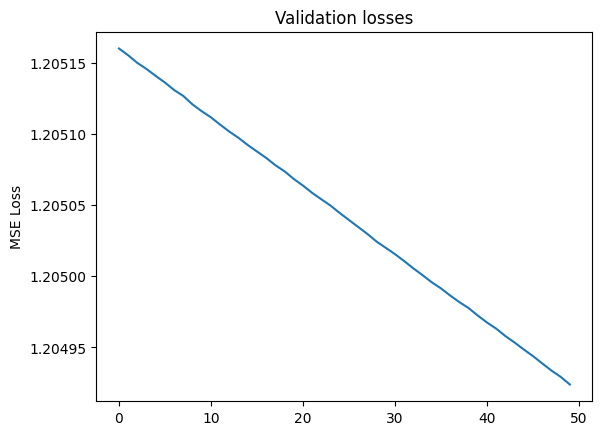

In [ ]:
# plt.plot(tr_losses)
plt.plot([loss.detach() for loss in val_losses])
plt.title("Validation losses")
plt.ylabel("MSE Loss")
plt.show()

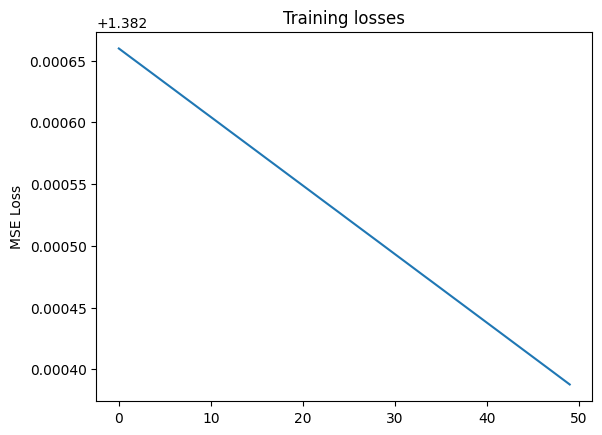

In [ ]:
plt.plot(tr_losses)
# plt.plot([loss.detach() for loss in val_losses])
plt.title("Training losses")
plt.ylabel("MSE Loss")
plt.show()


## Compare prediction vs ground truth

In [ ]:
yhat_distance = [yhat.detach().numpy().astype('float64') for yhat in yhat_train] # predicted distance
yhat_pos = np.stack(yhat_distance + np_train_features, axis=0) # add original feature position to predicted distance to plot coordinates 
print(len(yhat_train))
print(len(yhat_val))
print('distances original', train_distances[-1])
print('pred distances', yhat_distance[-1])
print('===============')
# print(len(y_hat_training))
# print(y_hat_np[0].shape)
# print(len(np_features[:799, :, :]))
# np.array_equal(y_hat_training, y_hat_np)
# print(y_hat_training[0])
# print(np_features[0, :, :])

999
500
distances original tensor([[ 1.5856e-02, -6.7275e-02,  4.5056e-02],
        [-2.4595e-02,  4.7894e-02, -3.1121e-02],
        [-3.2511e-02,  3.5928e-02, -9.5487e-02],
        [ 3.1446e-03, -6.9988e-02,  3.8046e-02],
        [ 4.5712e-02,  1.4918e-02,  1.5009e-01],
        [ 3.0858e-04, -1.2760e-02, -1.3440e-01],
        [-2.2111e-02,  6.9175e-02,  2.9728e-02],
        [ 6.7476e-03,  6.0942e-02,  1.5513e-01],
        [ 3.3897e-01, -1.0659e-01,  1.1092e-01],
        [-1.4174e-01,  4.9136e-02,  1.7753e-01],
        [ 2.2102e-01, -3.0738e-02, -3.5375e-01],
        [-2.5234e-02,  2.1593e-02, -2.0055e-01],
        [-3.2230e-02, -1.2911e-01,  1.3607e-01],
        [-2.0618e-01, -7.6798e-02, -2.7899e-02],
        [ 7.6956e-03, -1.4562e-03, -2.0244e-02]], dtype=torch.float64)
pred distances [[-6.82414137e-03 -3.00863967e-03 -2.70331395e-03]
 [-5.14293881e-03  6.34450559e-03 -1.15319970e-03]
 [-1.09062539e-02 -1.00071821e-02  1.45294378e-03]
 [-7.50263082e-03 -1.90333072e-02  3.86304408e-0

In [ ]:
yhat_distance_val = [yhatv.detach().numpy().astype('float64') for yhatv in yhat_val] # predicted distance
yhat_pos_val = np.stack(yhat_distance_val + np_val_features, axis=0) # add original feature position to predicted distance to plot coordinates 
print('distances original', val_distances[-1])
print('pred distances', yhat_distance_val[-1])
print('===============')

distances original tensor([[-0.0484, -0.1272, -0.2435],
        [-0.0138,  0.2059,  0.0579],
        [ 0.0200, -0.6148, -0.3360],
        [ 0.0255, -0.8405, -0.3214],
        [-0.0475, -0.1889, -0.0348],
        [ 0.0621,  0.7360,  0.5094],
        [ 0.0312,  0.9474,  0.4888],
        [-0.2015,  0.0235, -0.3965],
        [-0.0708, -0.1633, -0.2549],
        [-0.0426, -0.2047, -0.2511],
        [ 0.0417, -1.3641, -0.8408],
        [ 0.0423, -1.6590, -0.7133],
        [-0.0814, -0.4050, -0.1534],
        [ 0.1827,  1.0045,  0.6502],
        [-0.2164,  1.3639,  0.5259]], dtype=torch.float64)
pred distances [[-0.00360514 -0.00118762 -0.00482425]
 [-0.00254626 -0.00165337 -0.00336017]
 [-0.00863642 -0.00157415  0.00977873]
 [-0.00605012 -0.00146908  0.02312693]
 [-0.01337654  0.00428077 -0.00439715]
 [-0.00525236  0.00367389 -0.01359291]
 [-0.00149977 -0.00141126 -0.0075873 ]
 [-0.01796348  0.00271585  0.01077765]
 [-0.01081969 -0.00416287  0.001928  ]
 [-0.01874737  0.00188037 -0.01568733]

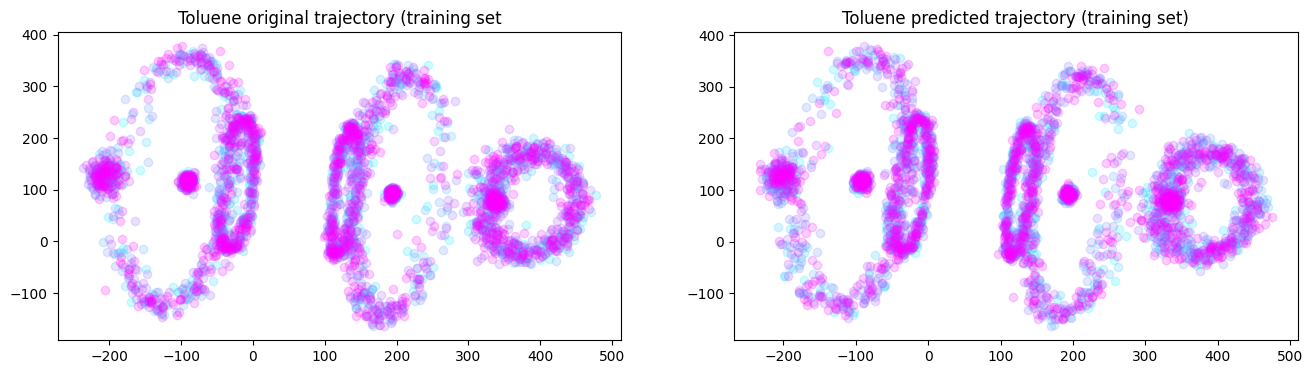

In [ ]:
# plot 3D coordinates on 2D Training
fig, axs = plt.subplots(ncols=2, squeeze=True, figsize=(16, 4))
axs[0].set_title('Toluene original trajectory (training set')
axs[1].set_title('Toluene predicted trajectory (training set)')
cmap = plt.get_cmap("cool")
for i in range(1, 989, 4):
    points2d, points3d = project_to_2D(np_train_labels[i])
    points2d_, points3d_ = project_to_2D(yhat_pos[i])
    axs[0].scatter(
        points2d[:, 0], points2d[:, 1],  alpha=0.2, color=cmap(i / 799)
    )
    axs[1].scatter(
        points2d_[:, 0], points2d_[:, 1],  alpha=0.2, color=cmap(i / 799)
    )
plt.show()

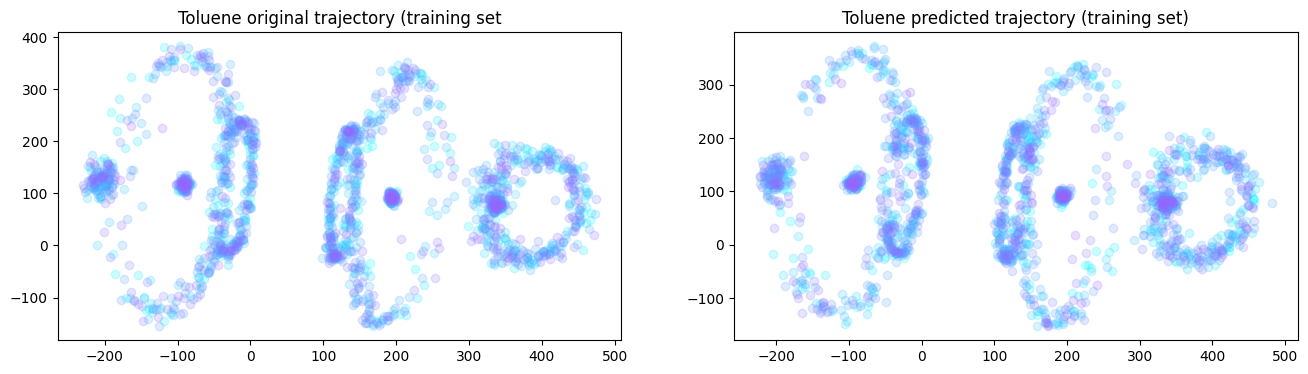

In [ ]:
# plot 3D coordinates on 2D Validation
fig, axs = plt.subplots(ncols=2, squeeze=True, figsize=(16, 4))
axs[0].set_title('Toluene original trajectory (training set')
axs[1].set_title('Toluene predicted trajectory (training set)')
cmap = plt.get_cmap("cool")
for i in range(1, 500, 4):
    points2d, points3d = project_to_2D(np_val_labels[i])
    points2d_, points3d_ = project_to_2D(yhat_pos_val[i])
    axs[0].scatter(
        points2d[:, 0], points2d[:, 1],  alpha=0.2, color=cmap(i / 799)
    )
    axs[1].scatter(
        points2d_[:, 0], points2d_[:, 1],  alpha=0.2, color=cmap(i / 799)
    )
plt.show()

In [ ]:
# plot training labels and prediction training
# fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}]])
frame = 0
opacity=0.1
for i in range(1, 799, 4):
    fig.add_trace(go.Scatter3d(x=yhat_pos[i, :, 0], y=yhat_pos[i, :, 1], z=yhat_pos[i, :, 2],
                               mode='markers', 
                               marker=dict(
                                   color="blue",
                                   size=15,
                                   opacity=0.2
                               )
                              ), row=1, col=2)
    fig.add_trace(go.Scatter3d(x=np_train_labels[i, :, 0], y=np_train_labels[i, :, 1], z=np_train_labels[i, :, 2],
                               mode='markers', 
                               marker=dict(
                                   color="blue",
                                   size=15,
                                   opacity=0.2
                               )
                              ), row=1, col=1)
    frame +=100
    opacity +=0.1
fig.update_layout(margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    ))
fig.show()

In [ ]:
# plot training labels and prediction valiation
# fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}]])
frame = 0
opacity=0.1
for i in range(1, 500, 4):
    fig.add_trace(go.Scatter3d(x=yhat_pos_val[i, :, 0], y=yhat_pos_val[i, :, 1], z=yhat_pos_val[i, :, 2],
                               mode='markers', 
                               marker=dict(
                                   color="blue",
                                   size=15,
                                   opacity=0.2
                               )
                              ), row=1, col=1)
    fig.add_trace(go.Scatter3d(x=np_val_labels[i, :, 0], y=np_val_labels[i, :, 1], z=np_val_labels[i, :, 2],
                               mode='markers', 
                               marker=dict(
                                   color="blue",
                                   size=15,
                                   opacity=0.2
                               )
                              ), row=1, col=2)
    frame +=100
    opacity +=0.1
fig.update_layout(margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    ))
fig.show()